In [26]:
import numpy as np
import pandas as pd
import scipy 
import numpy.matlib
import seaborn as sns
import nilearn
import random
import matplotlib.pyplot as plt
import nilearn
from nilearn import plotting
from nilearn import datasets
import urllib
from sklearn import linear_model 
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [27]:
# motor and value areas functional connectivity matrix
task_fc = pd.read_csv('task_fc_per_block.csv', index_col = 'Subject')
# inconsistency measures: GARP, Varian, Afriat, Houtman-Maks, MMI
behavioral_results = pd.read_csv('../data/aggregate_indices_subs101_148_08Dec2020.csv', index_col = 'Subject')

In [28]:
X = task_fc
# choose only subjects that did a resting scan
Ys = behavioral_results.loc[task_fc.index]
# shorten names of variables
Ys = Ys.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)
all_measures = ['GARP Violations', 'Afriat Index', 'Varian Index', 'Houtman Maks Index', 'MMI']

In [29]:
# write data for R model
len(Ys)

43

In [30]:
# remove perfectly-consistent subjects
inconsistent_subjects = Ys.loc[:, 'GARP Violations']!=0
Ys_incon = Ys.loc[inconsistent_subjects, :]
X_incon = X.loc[inconsistent_subjects, :]

In [31]:
Ys.shape

(43, 14)

<AxesSubplot:>

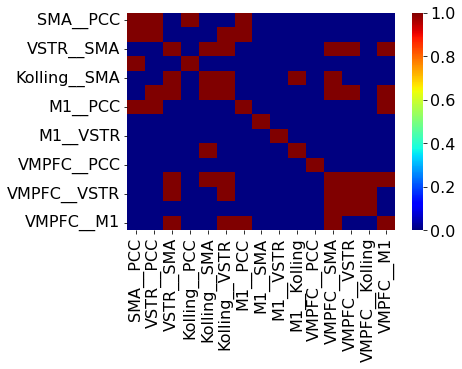

In [32]:
sns.heatmap(X.corr()>0.7, cmap='jet')

In [33]:
# Y's correlation matrix
Ys_incon.loc[:, all_measures].corr()

,GARP Violations,Afriat Index,Varian Index,Houtman Maks Index,MMI
GARP Violations,1.000000,0.926514,0.972788,0.893275,0.795288
Afriat Index,0.926514,1.000000,0.982546,0.903812,0.837014
Varian Index,0.972788,0.982546,1.000000,0.916406,0.818154
Houtman Maks Index,0.893275,0.903812,0.916406,1.000000,0.886821
MMI,0.795288,0.837014,0.818154,0.886821,1.000000


In [34]:
def select_features(X, y, pval_thresh, number_thresh = 0):
    '''
    Feature selection function. Selects the top features (X) that are most correlated with y, in absolute value.
    Thresholding can be done using correlation's p value or number of top features.
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - numpy float array
                target vairable
            pval_tresh - float
                threshold of correlations' p value to include in the selected features
            number_thresh -  int
                number of features to select
            
    Returns
    ----------------------------
            top_features - string list
                list of the selected features 
    '''
    if number_thresh != 0:
        # select top features using number_thresh
        column_len = len(X.columns)
        # create matrix of repeated Ys in the size of len(X) x len(Y)
        y_mat = np.matlib.repmat(y, column_len, 1)
        # correlate between X and Y save absolute values
        x_y_corr = np.corrcoef(X.transpose(), y_mat)
        abs_corr = np.abs(x_y_corr)
        # sort features and select the top number_thresh features
        top_indices = np.argsort(abs_corr[column_len, 0:column_len])
        top_features = X.columns[top_indices[-1 * number_thresh:]]
    else:
        # select top features using p-value
        top_features = []
        corrs = []
        # calculate the correlation of each feature with y, choose only correlations with p-value < pval_thresh
        for feature in X.columns:
            feature_data = X.loc[:, feature]
            r, pval = correlation_permuation_test(feature_data, y)
            if pval < pval_thresh:
                top_features.append(feature)
                corrs.append(r)
    return top_features

In [35]:
def random_forest_model(X, y, measure, model_type, k_cv=3):
    
    models = []
    scores = []
    y = np.log(y.loc[:, measure])
    n_estimators = np.linspace(60, 250, 10, dtype=int)
    n_estimators = np.insert(n_estimators, 0, 100)
    max_features = ['auto', 'sqrt']
    max_depth = np.linspace(10, 100, 5, dtype=int)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2]
    learning_rate = [1, 2, 3]
    if model_type == 'RandomForest':
        param_grid = {'n_estimators' : n_estimators,
                     'max_features' : max_features,
                     'max_depth' : max_depth,
                     'min_samples_split' : min_samples_split,
                     'min_samples_leaf' : min_samples_leaf}
        model = RandomForestRegressor(n_jobs = -1, random_state = 42)
        # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 4000, 
                                #    cv = 3, n_jobs = -1, random_state = 42)
        model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=k_cv)
    elif model_type == 'Xgboost':
        model = xgb.XGBRegressor()
        param_grid = {'n_estimators' : n_estimators,
                      'max_depth' : np.linspace(10, 100, 2, dtype=int),
                      'learning_rate' : learning_rate}
        # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 100, 
                            #   cv = k_cv, n_jobs = -1, random_state = 42)  
        model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=None, cv=k_cv)

    
    features = X.columns
    features = features.append(pd.Index(['Score']))
    coef_df = pd.DataFrame(features, columns = ['Feature'])

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        # scale y_train
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        y_train = (y_train - mean_y) / std_y
        # scale y_test with *y_train*
        y_test = (y_test - mean_y) / std_y
        
        model_cv.fit(X_train, y_train)
        best_model = model_cv.best_estimator_
        
        y_pred = best_model.predict(X_test)
        models.append((best_model, X_train))
        score = metrics.mean_squared_error(y_test, y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        coefs = pd.DataFrame(best_model.feature_importances_)
        coef_df['Coefficient' + str(i)] = np.append(coefs, score)
        coefs_list = coef_df
      
        i += 1
    return coefs_list, y_hats, y_true, models

In [36]:
# Random Forest CV
coef_df_schaefer, sch_y_hats, sch_y_true, models = random_forest_model(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure)
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
sch_avg_forest, sch_forest_score = average_coefs(coef_df_schaefer)
print(f'MSE: {sch_forest_score:.3f}')
draw_glassbrain(sch_avg_forest[:5].reset_index(drop=True))

NameError: name 'schaefer_mat' is not defined

In [37]:
def linear_models(X, y, measure, model_type, feature_number):
    '''
    Trains a model: Linear, LASSO, Ridge, ElasticNet, or RandomForest. 
    Split train/test, selects features and predicts in with a leave-one-out procedure
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - pandas DataFrame
                DataFrame of target vairables
            measure - string
                name of target variable
            model_type - string
                string of model type, either:
                    'Linear' - regular linear regression
                    'Lasso' - LASSO regression
                    'Ridge' - Ridge regression
                    'Elastic' - ElasticNet regression
                    'Random Forest' - Random Forest regression
            feature_number - int
                number of features to select

    Returns
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
            y_hats - float array
                predicted target values
            y_true - float array
                true target values
            models - sklearn regressors list
                list of models used in the leave-one-out procedure
    '''
    
    models = []
    scores = []
    # transform y top log(y)
    y = np.log(y.loc[:, measure])
    
    # initiate models, based on model_type
    if model_type == 'Elastic':
        model = linear_model.ElasticNetCV(l1_ratio = np.arange(0.01, 1, 0.02), cv = 5, alphas = np.arange(0.01, 1, 0.01), max_iter=50000, n_jobs = -1)
    elif model_type == 'Ridge': 
        model = linear_model.RidgeCV(alphas = np.arange(0.01, 5, 0.01), cv = 5)
    elif model_type == 'Lasso': 
        model = linear_model.LassoCV(alphas = np.arange(0.01, 5, 0.01), cv = 5, max_iter = 50000, n_jobs = -1)
    elif model_type == 'Linear':
        model = linear_model.LinearRegression(n_jobs = -1)
    elif model_type == 'Random Forest':
        model = RandomForestRegressor(n_jobs = -1, random_state = 42)
        features = X.columns
        features = features.append(pd.Index(['Score']))
        coef_df = pd.DataFrame(features, columns = ['Feature'])

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        # select top N features with highest correlation with y_train
        if model_type != 'Random Forest':
            selected_features = select_features(X_train, y_train, 0.05, feature_number)
            X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        # scale y_train
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        y_train = (y_train - mean_y) / std_y
        # scale y_test with *y_train*
        y_test = (y_test - mean_y) / std_y
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        # save the models, scores and predicted values
        models.append(model)
        score = metrics.mean_squared_error(y_test, y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        if model_type == 'Random Forest':
            # save model's feature importance in DataFrame, each column is the importance of the i-th model
            coefs = pd.DataFrame(model.feature_importances_)
            coef_df['Coefficient' + str(i)] = np.append(coefs, score)
            # for RandomForest there is only one dataframe (coef_df), so the list of length one 
            coefs_list = coef_df
        else:
            # save model's coefficients in DataFrame

            features = X_train.columns
            features = features.append(pd.Index(['Score']))
            coef_df = pd.DataFrame(features, columns = ['Feature'])
            coefs = model.coef_
            coef_df['Coefficient'] = np.append(coefs, score)
            # each model might have different sets of features, so we append all DataFrames to a list 
            coefs_list.append(coef_df)
        i += 1
    return coefs_list, y_hats, y_true, models

In [38]:
def correlation_permuation_test(y_pred, y_true):
    '''
    Test correlation between predicted and true target values using a permuation test
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
        
    Returns
    ----------------------------
        r - float
            correlation between true and predicted target values
        pval - float
            p-value of the correlation, calculated using a permutation test
    '''
    permutations = 10000
    r, _ = scipy.stats.pearsonr(y_pred, y_true)
    y_pred_permute = y_pred.copy()
    corr_distribution = []

    for i in range(permutations):
        # for each permuation shuffle the predicted values between subjects, and calculate correlation with the true values 
        random.shuffle(y_pred_permute)
        this_corr, _ = scipy.stats.pearsonr(y_pred_permute, y_true)
        corr_distribution.append(this_corr)
        
    pval = sum(r <= corr_distribution) / len(corr_distribution)
    return r, pval, corr_distribution

In [39]:
def print_results(y_true, y_pred, measure, model):
    '''
    Plots results of the prediction models in a scatter plot with regression line and its p-value
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
            measure - string
                name of target variable
            model - string
                name of model for figure title (Linear Regression / Random Forest)
                
    Returns
    ----------------------------
            r - float
                correlation between true and predicted target values
            pval - float
                p-value of the correlation, calculated using a permutation test
    '''
    r, pval, corr_distribution = correlation_permuation_test(y_pred, y_true)
    
    # plot correlation between predicted and true
    fig = plt.figure(figsize = (8, 5))
    ax = fig.add_subplot()
    plt.scatter(y_true, y_pred)
    plt.title(model + ' Model')
    plt.xlabel('True ' + measure + ' (Normalized)')
    plt.ylabel('Predicted ' + measure)
    plt.ylim(bottom = -1.3, top = 1.3)
    plt.text(0.75, 0.03, 'r = {:.4f}'.format(r) + '\np-val = {:.4f}'.format(pval), transform = ax.transAxes, fontsize = 14)
    font = {'family' : 'sans-serif',
            'weight' : 'regular',
            'size'   : 16}
    plt.rc('font', **font)
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    _ = plt.plot(y_true, np.multiply(y_true, slope) + intercept)
    
    # plot correlation distribution
    plt.figure(figsize = (8, 5))
    plt.hist(corr_distribution, bins = 50)
    baseline_r = np.mean(corr_distribution)
#     print(f'Baseline: {baseline_r} \nReal r: {r} \n Correlation p-value: {pval}')
    plt.title('Correlation Distribution')
    avg_line = plt.vlines(x = baseline_r, ymin = 0, ymax = 600, colors = 'orange', linestyles = '--')
    real_line = plt.vlines(x = r, ymin = 0, ymax = 600, colors = 'red', linestyles = '--')
    plt.legend([avg_line, real_line], ['Average Correlation', f"Model's Correlation"], fontsize = 12, loc = 'upper left')
    plt.xlabel('Permuted Pearson Correlation Value')
    plt.ylabel('Frequency')
    
    return r, pval

In [40]:
def average_coefs(coef_df_list):
    '''
    Returns average coefficients of the prediction models.
    
    Parameters
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
    
    Returns
    ----------------------------
            avg_coefs - DataFrame
                DataFrame of average coefficient of all models
            score - float
                average score of models' predictions
    '''
    # if coef_df_list is a list, it contains coefficients of linear models
    if type(coef_df_list) == list:
        number_of_models = len(coef_df_list)
        avg_coefs = pd.DataFrame()
        for i in range(number_of_models):
            coef_df = coef_df_list[i]
            coef_df = coef_df.loc[coef_df.Coefficient != 0]
            coef_df = coef_df.reset_index(drop = True)
            for feature_i in range(len(coef_df)):
                feature = coef_df.Feature[feature_i]
                # if the feature was already in previous models, sum the cofficients
                if feature in avg_coefs.axes[0]:
                    avg_coefs.loc[feature, 'Beta'] = avg_coefs.loc[feature, 'Beta'] + coef_df.iloc[feature_i, 1]
                    avg_coefs.loc[feature, 'Count'] = avg_coefs.loc[feature, 'Count'] + 1
                # else, create a new feature in the dataframe
                else:
                    avg_coefs.loc[feature, 'Beta'] = coef_df.iloc[feature_i, 1]
                    avg_coefs.loc[feature, 'Count'] = 1
        # sort features by count, as features that appear in more models are more important
        avg_coefs = avg_coefs.sort_values(by = 'Count')
        avg_coefs = avg_coefs.reset_index()
        avg_coefs.columns = ['Feature', 'Beta', 'Count']
        # average betas
        avg_coefs.Beta = avg_coefs.Beta / number_of_models
        # find the score and exclude it from avg_coefs
        score_index = avg_coefs.index[avg_coefs.Feature == 'Score'].to_list()[0]
        score = avg_coefs.iloc[score_index, 1]
        avg_coefs = avg_coefs.drop(index = score_index)
    # if coef_df_list isn't a list, it contains feature importance measures of Random Forest models
    else:
        # find the score and exclude it from avg_coefs
        score_index = coef_df_list.index[coef_df_list.Feature == 'Score'].to_list()[0]
        score = np.mean(coef_df_list.iloc[score_index, 1:].to_list())
        coef_df_list = coef_df_list.drop(index = score_index)
        # average feature importance
        agg_importance = np.mean(coef_df_list, axis = 1)
        sort_i = agg_importance.argsort()
        features = coef_df_list.Feature.values
        importance_df = pd.DataFrame([features[sort_i], agg_importance[sort_i]]).transpose()
        importance_df.columns = ['Feature', 'Beta']
        avg_coefs = importance_df.sort_values(by = 'Beta', ascending=False)
        
    return avg_coefs, score

In [41]:
def threshold_p(feature_list, p):
    '''
    '''
    absolute_feautres = np.abs(feature_list)
    absolute_feautres.sort()
    absolute_feautres = absolute_feautres[::-1]
    threshold_index = int(len(feature_list) * p)
    threshold = absolute_feautres[n - 1]
    return threshold

In [42]:
def threshold_n(feature_list, n):
    absolute_feautres = np.abs(feature_list)
    absolute_feautres.sort()
    absolute_feautres = absolute_feautres[::-1]
    threshold = absolute_feautres[n - 1]
    return threshold

In [43]:
def draw_glassbrain(importance_df):
    '''
    Draw glass-brain including the top 5 connetivity features based on importance_df.
    
    Parameters
    ----------------------------
            importance_df - DataFrame
                DataFrame containing coefficients or feature importance of features of a model
    
    '''
    # initiate atlas and labels
    parcels_text = urllib.request.urlopen("https://raw.githubusercontent.com/asafmm/inconsistency_functional_connectivity/main/Schaefer2018_100Parcels_7Networks_order_info.txt").read()
    # convert from 'binary' to normal string
    parcels_text = parcels_text.decode('ascii')
    # select only even rows, which contain the labels 
    lines = parcels_text.split('\n')[:-1]
    lines = lines[::2]
    # remove prefix from label: "7Networks_"
    parcel_list = [parcel[10:] for parcel in lines]

    schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7).maps
    coordinates = plotting.find_parcellation_cut_coords(labels_img=schaefer)

    for i in range(len(importance_df)):
        # extract each node's name (splitted by "__")
        node1_name = importance_df['Feature'][i].split('__')[0]
        node2_name = importance_df['Feature'][i].split('__')[1] 
        importance_df.loc[i, 'Node1'] = int(parcel_list.index(node1_name))
        importance_df.loc[i, 'Node2'] = int(parcel_list.index(node2_name))

    # create features matrix
    node_number = 100
    features_matrix = np.zeros([node_number, node_number])
    for i in range(len(importance_df)):
        row, col = int(importance_df.loc[i, 'Node1']), int(importance_df.loc[i, 'Node2'])
        features_matrix[row, col] = importance_df.loc[i, 'Beta']
        # symmetric matrix, so [row, col] == [col, row]
        features_matrix[col, row] = importance_df.loc[i, 'Beta']
    
    # draw brain
    colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
    net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
    color_dict = dict(zip(net_names, colors_list))
    node_colors = []
    for name in parcel_list:
        net = name.split('_')[1]
        node_colors.append(color_dict[net])
    # find top 5 features 
    thresh = threshold_n(importance_df.Beta.to_list(), 5)
    _ = plotting.plot_connectome(features_matrix, coordinates, edge_threshold = thresh,
                                 display_mode = 'lzry', node_size = 25, node_color = node_colors, colorbar = True)

#### Choose inconsistency index

In [44]:
inconsistency_measure = 'Varian Index'

# Motor-Value Matrix

MSE: 1.301


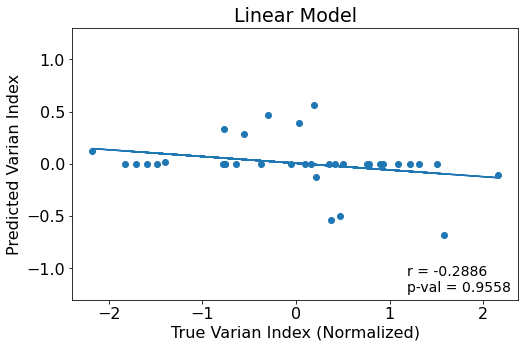

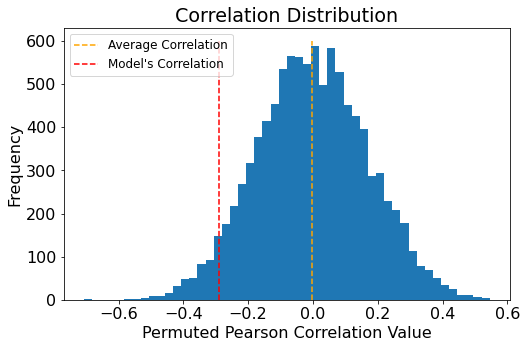

In [45]:
# Linear regression
coef_df, y_hats, y_true, models = linear_models(task_fc.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Lasso', 45)
r, pval = print_results(y_true, y_hats, inconsistency_measure, 'Linear')
avg_cofs, score = average_coefs(coef_df)
print(f'MSE: {score:.3f}')
# motor_linear_avg[-5:]

MSE: 1.240


/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


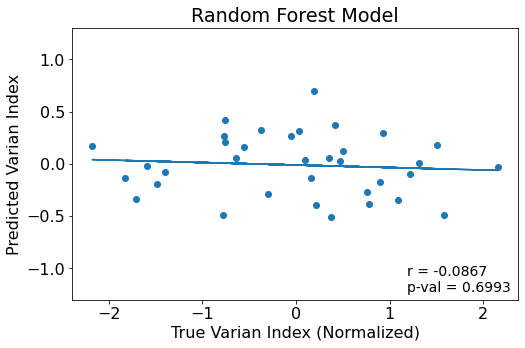

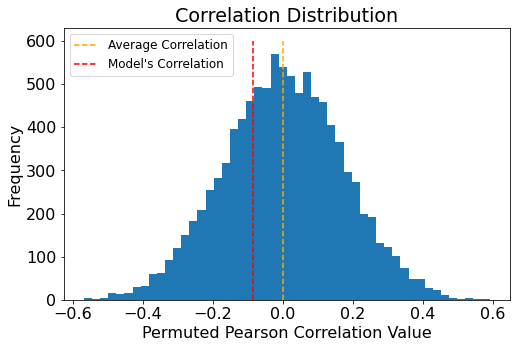

In [47]:
# RandomForest regression
coef_df_rf, y_hats_rf, y_true_rf, rf_models = random_forest_model(task_fc.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'RandomForest')
r, pval = print_results(y_true_rf, y_hats_rf, inconsistency_measure, 'Random Forest')
avg_cofs_rf, score_rf = average_coefs(coef_df_rf)
print(f'MSE: {score_rf:.3f}')
# motor_linear_avg[-5:]

# Whole-brain Matrix

MSE: 1.013


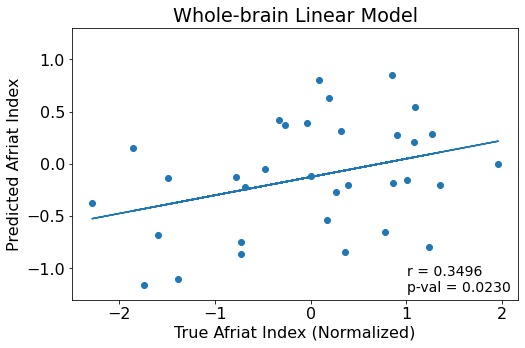

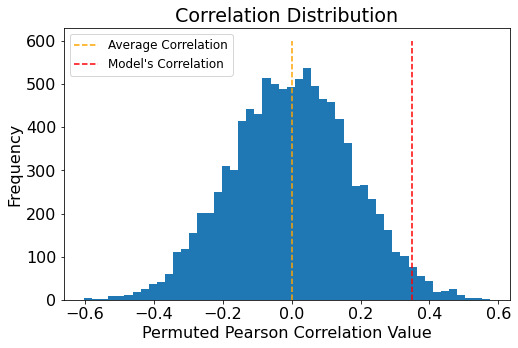

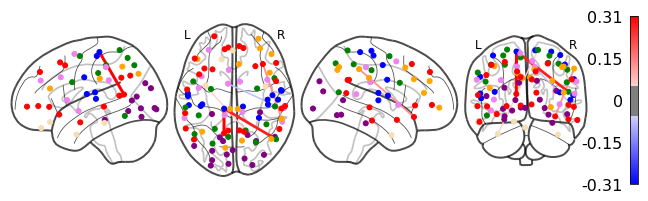

In [519]:
# Schaefer linear regression
coef_df_schaefer, sch_y_hats, sch_y_true, models = linear_models(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Lasso', 45)
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Linear')
sch_avg_linear, sch_linear_score = average_coefs(coef_df_schaefer)
print(f'MSE: {sch_linear_score:.3f}')
draw_glassbrain(sch_avg_linear[-5:].reset_index(drop=True))

MSE: 0.903


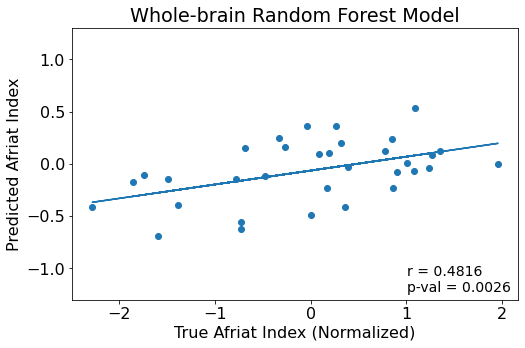

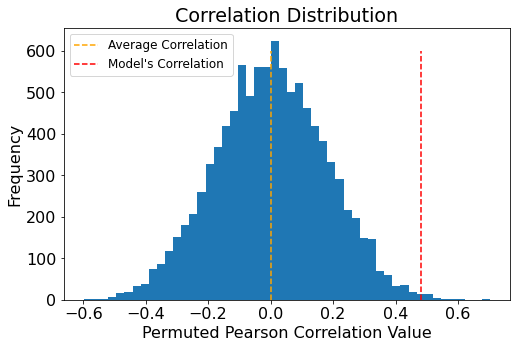

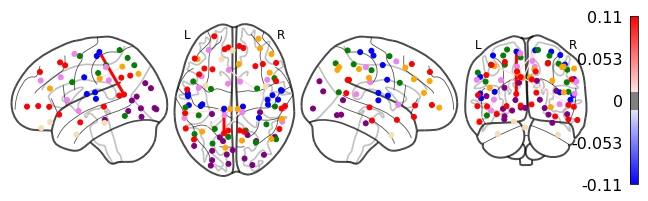

MSE: 0.833


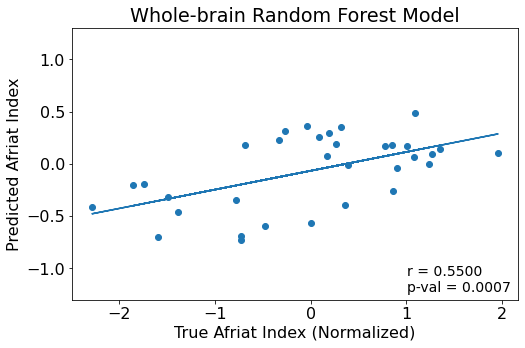

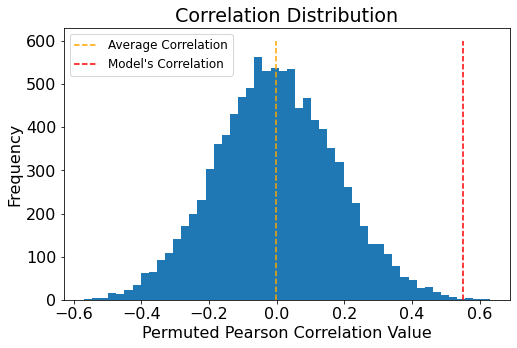

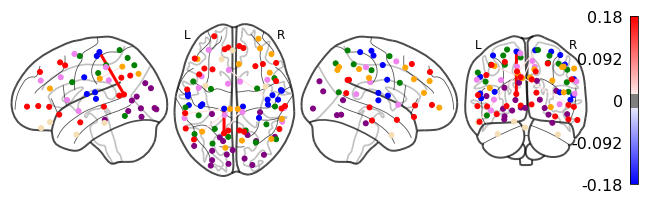

In [520]:
# Schaefer Random Forest
coef_df_schaefer, sch_y_hats, sch_y_true, models = linear_models(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Random Forest', 0)
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
sch_avg_forest, sch_forest_score = average_coefs(coef_df_schaefer)
print(f'MSE: {sch_forest_score:.3f}')
draw_glassbrain(sch_avg_forest[:5].reset_index(drop=True))

## Dino's comments
### To do ###
1. Average matrices for value-motor and Schaefer
2. Check feature correlation matrix and remove highly correlated features
3. Interpretability - What is the relation between the connectivity and the inconsistency? Stronger -> less consistent

#### Done ###
1. Is the fisher transform necessary? - yes, affects results. why?
2. Check more models: Random Forrest, SVM?, Xgboost - RF is the best
3. X axis only negative - make sure the order is saved before and after transformation - the order is saved
4. Change axes values, so they make sense - fixed
5. Squared error - comparing models
6. Add a 45-angle line to compare - dismissed, doesn't look good
7. Draw glass brain 

## Vered's comments
#### Done ####
1. Correlation matrix for Inocnsistency measures
2. Draugowitz - 3 sources for inconsistency
3. Emily Finn - take only top correlations with the y

#### To do? #####
* transform measures to ordinary scale and correlate fc_matrix to ordinary scale
* predict task fmri form rest ??? - Consult with Ido
* Stepwise regression

## Unused - Multiple Regression of Varian ~ features

In [13]:
import statsmodels.api as sm

In [411]:
# Simple regression - Motor-value
measure = all_measures[2]
y = np.log(Ys_incon.loc[:, measure])
X = X_incon
X_ols = sm.add_constant(X)
lm = sm.OLS(y, X_ols)
fitted_model = lm.fit()
print(fitted_model.summary())

                              OLS Regression Results                             
Dep. Variable:     VARIAN Index AVG(SSQ)   R-squared:                       0.980
Model:                               OLS   Adj. R-squared:                  0.837
Method:                    Least Squares   F-statistic:                     6.889
Date:                   Tue, 10 Aug 2021   Prob (F-statistic):             0.0364
Time:                           16:20:21   Log-Likelihood:                -2.2787
No. Observations:                     33   AIC:                             62.56
Df Residuals:                          4   BIC:                             106.0
Df Model:                             28                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

In [547]:
# Simple regression - Whole brain
measure = all_measures[2]
top_features = select_features(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon.loc[:, measure], 0.05, 45)
y = np.log(Ys_incon.loc[:, measure])
X = schaefer_mat.loc[inconsistent_subjects, top_features]
lm = linear_model.LassoCV(max_iter = 50000, n_jobs = -1)
lm.fit(X, y)

LassoCV(max_iter=50000, n_jobs=-1)

In [557]:
X['Varian'] = y.values

In [558]:
# write X to csv for Rstudio
X.to_csv('/Users/elaine/Dropbox/LabDropbox/Asaf/python/whole_brain.csv')


                              WLS Regression Results                             
Dep. Variable:     VARIAN Index AVG(SSQ)   R-squared:                       0.974
Model:                               WLS   Adj. R-squared:                  0.582
Method:                    Least Squares   F-statistic:                     2.486
Date:                   Tue, 10 Aug 2021   Prob (F-statistic):              0.328
Time:                           17:20:06   Log-Likelihood:                -6.4227
No. Observations:                     33   AIC:                             74.85
Df Residuals:                          2   BIC:                             121.2
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

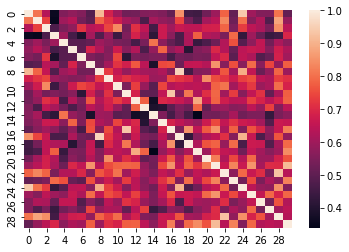

In [520]:
# Simple regression - Whole brain
measure = all_measures[2]
top_features = select_features(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon.loc[:, measure], 0.05, 30)
y = np.log(Ys_incon.loc[:, measure])
X = schaefer_mat.loc[inconsistent_subjects, top_features]
#X = (X - np.mean(X)) / np.std(X)
sns.heatmap(np.corrcoef(X.transpose()))
X_ols = sm.add_constant(X)
lm = sm.OLS(y, X_ols)
fitted_model = lm.fit()
print(fitted_model.summary())

In [401]:
selected_features.get_loc('LH_Default_PFC_6_LH_Limbic_TempPole_2')

1

In [394]:
############## UNFINISHED - DOESN'T WORK
# def remove_multicollinearity(X):

selected_features = X.columns
count = 0
finished = 0
i = 1
while True:
    if i >= len(X.columns)-1:
        break
    else:
        if X.columns[i] not in selected_features:
            i += 1
        else:
            feature_i = X.columns[i]
            print(feature_i)
            data_i = X.loc[:, feature_i]
            j = selected_features.get_loc(feature_i) + 1
            while True:
                if j >= len(selected_features):
                    break
                else:
                    feature_j = selected_features[j]
                    data_j = X.loc[:, feature_j]
                    cor_ij = np.corrcoef(data_i, data_j)[0, 1]
                    if cor_ij > 0.7:
                        selected_features = selected_features.drop(feature_j)
                        count += 1
                    j += 1
            i += 1
#    return selected_features

LH_Default_PFC_6_LH_Limbic_TempPole_2
LH_Default_pCunPCC_2_LH_SomMot_2
RH_Default_Temp_2_RH_SomMot_8
RH_Default_pCunPCC_1_RH_SomMot_6
RH_Limbic_OFC_1_LH_DorsAttn_Post_5
LH_Cont_Cing_1_LH_SomMot_6
RH_SomMot_8_LH_Limbic_OFC_1
RH_Limbic_OFC_1_RH_SalVentAttn_TempOccPar_2
RH_Default_pCunPCC_1_RH_SalVentAttn_Med_2
LH_Default_PFC_3_LH_SomMot_1
RH_DorsAttn_Post_5_LH_Limbic_OFC_1
RH_Limbic_TempPole_1_RH_DorsAttn_Post_5
RH_SalVentAttn_Med_2_LH_Default_PFC_3
